In [ ]:
# Install required libs
# !pip uninstall -y segmentation-models-pytorch
!pip install -U segmentation-models-pytorch --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=170eec1c735898a39c248bd151c5ef33f97f50a0588a53a0aae54f5968517071
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=a79b571876e0b09ad89c60c2e2bedb09b5c4b603e4f63964db79f6f768bf6aec
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


# Go to git repository

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

tdd_path = "/content/drive/MyDrive/Github/tdd-model/dataset/Tufts Dental Database"
repo_path = "/content/drive/MyDrive/Github/tdd-model"
%cd "$repo_path"
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Github/tdd-model
assets/   Detectron2_Tutorial.ipynb  models/  README.md                  tdd_utils/
dataset/  main.ipynb                 others/  segmentation_models.ipynb


## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks

All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tdd_utils.dataset import load_dataset

In [ ]:
# # create train, val, test datasets
# !python "utils/dataset.py"

In [ ]:
dataset_path = '/content/drive/MyDrive/Github/tdd-model/dataset'

train_path = os.path.join(dataset_path, 'train.pkl')
val_path = os.path.join(dataset_path, 'val.pkl')
test_path = os.path.join(dataset_path, 'test.pkl')

train = load_dataset(train_path)
val = load_dataset(val_path)
test = load_dataset(test_path)

In [ ]:
train[:2]

[{'file_name': '/content/drive/MyDrive/Github/tdd-model/dataset/Tufts Dental Database/Radiographs/721.JPG',
  'height': 840,
  'width': 1615,
  'annotations': <840x1615 sparse matrix of type '<class 'numpy.uint8'>'
  	with 11308 stored elements in COOrdinate format>,
  'class_counts': {'benign_cyst_neoplasia': 10,
   'developmental': 0,
   'inflammation': 0}},
 {'file_name': '/content/drive/MyDrive/Github/tdd-model/dataset/Tufts Dental Database/Radiographs/473.JPG',
  'height': 840,
  'width': 1615,
  'annotations': <840x1615 sparse matrix of type '<class 'numpy.uint8'>'
  	with 0 stored elements in COOrdinate format>,
  'class_counts': {'benign_cyst_neoplasia': 0,
   'developmental': 0,
   'inflammation': 0}}]

In [ ]:
# # helper function for data visualization
# def visualize(**images):
#     """PLot images in one row."""
#     n = len(images)
#     plt.figure(figsize=(16, 5))
#     for i, (name, image) in enumerate(images.items()):
#         plt.subplot(1, n, i + 1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.title(' '.join(name.split('_')).title())

#         plt.imshow(image, cmap='gray')

#     plt.show()

In [ ]:
def visualize(image, gt_mask, pr_mask=None):
    """
    Plot image, ground truth mask, and predicted mask (optional).
    Assign different colors to each class in the mask.
    """
    class_colors = {
        0: (0, 0, 0),   # Black (background)
        1: (1, 0, 0),   # Red (cyst)
        2: (0, 1, 0),   # Green (developmental)
        3: (0, 0, 1),   # Blue (inflammation)
    }

    n_classes = gt_mask.shape[2]
    mask_colored = np.zeros((gt_mask.shape[0], gt_mask.shape[1], 3), dtype=np.float32)

    for i in range(n_classes):
        mask_colored += np.expand_dims(gt_mask[:, :, i], axis=2).astype(np.float32) * np.array(class_colors[i])

    mask_colored = np.clip(mask_colored, 0, 1)  # Clip values to the valid range [0, 1]

    plt.figure(figsize=(16, 5))

    # Plot Image
    plt.subplot(1, 2 + (pr_mask is not None), 1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Image')
    plt.imshow(image[:, :, 0], cmap='gray')

    # Plot Ground Truth Mask
    plt.subplot(1, 2 + (pr_mask is not None), 2)
    plt.xticks([])
    plt.yticks([])
    plt.title('Ground Truth Mask')
    plt.imshow(mask_colored)

    # Plot Predicted Mask (optional)
    if pr_mask is not None:
        prediction_colored = np.zeros((pr_mask.shape[0], pr_mask.shape[1], 3), dtype=np.float32)
        for i in range(n_classes):
            prediction_colored += np.expand_dims(pr_mask[:, :, i], axis=2).astype(np.float32) * np.array(class_colors[i])

        prediction_colored = np.clip(prediction_colored, 0, 1)  # Clip values to the valid range [0, 1]

        plt.subplot(1, 2 + (pr_mask is not None), 3)
        plt.xticks([])
        plt.yticks([])
        plt.title('Predicted Mask')
        plt.imshow(prediction_colored)

    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

from pathlib import Path
from typing import Any, Callable, Optional

import numpy as np
from PIL import Image
from torchvision.datasets.vision import VisionDataset

In [ ]:
class SegmentationDataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """
    CLASSES = ["BG","benign_cyst_neoplasia", "developmental", "inflammation"]

    def __init__(
            self,
            dataset_objs = [],
            augmentation=None,
            preprocessing=None,

    ):
        self.class_values = [i for i in range(len(self.CLASSES))]
        self.image_names = []
        self.seg_masks = []
        self.has_abnormalities = []
        for obj in dataset_objs:
            self.image_names.append(obj['file_name']) # get image file names
            self.seg_masks.append(obj['annotations'].toarray()) # get (h,w) sparse mask then convert to binary
            self.has_abnormalities.append(True if sum(obj['class_counts'].values()) > 0 else False)

        # convert str names to class values on masks
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # read data
        image = np.asarray(Image.open(self.image_names[i]).convert("L"), dtype="uint8")
        image = np.expand_dims(image, axis=-1)

        mask = self.seg_masks[i]
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        has_abnormality = self.has_abnormalities[i]

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.image_names)

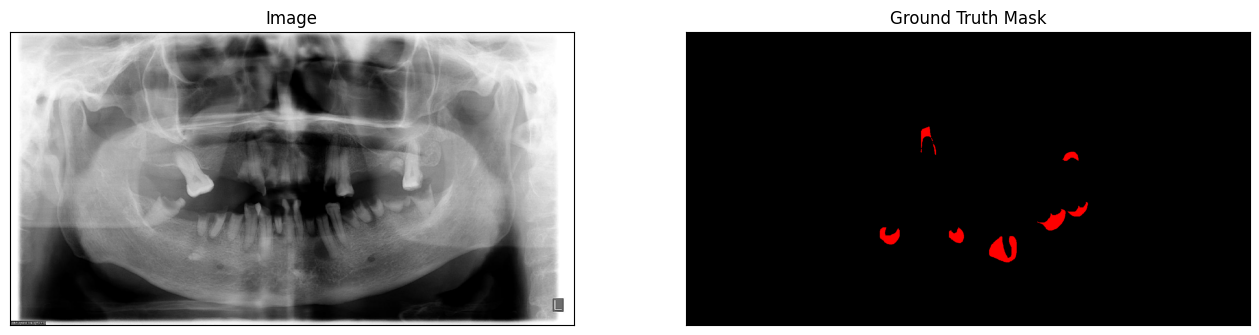

In [ ]:
# Lets look at data we have
dataset = SegmentationDataset(dataset_objs=train)

image, mask = dataset[0]

visualize(
    image=image,
    gt_mask=mask,
)
del dataset

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [ ]:
import albumentations.pytorch
import albumentations as albu
import cv2

In [ ]:
def get_training_augmentation(
    bright_range= .2,
    crop_height = 768,
    crop_width = 1472,
    desired_height = 256,
    desired_width = 512,
    probs = (.5, .5, .5, .5, .5)
):
    """add train augmentations"""
    crop_p, flip_p, bright_p, _, _ = probs
    transform_list = [
        albu.RandomCrop(height=crop_height, width=crop_width, p=crop_p),
        albu.Resize(height=desired_height, width=desired_width, always_apply=True),
        albu.HorizontalFlip(p=flip_p),
        albu.RandomBrightnessContrast(brightness_limit=bright_range, contrast_limit=bright_range, p=bright_p),
    ]


    return albu.Compose(transform_list)

def get_validation_augmentation(
    desired_height = 256,
    desired_width = 512,
):
    """add test augmentations"""
    test_transform = [
        albu.Resize(height=desired_height, width=desired_width, always_apply=True),
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform"""

    transform_list = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(transform_list)

augs = get_training_augmentation()
transformed_image = augs(image=image)
visualize(transformed_image)

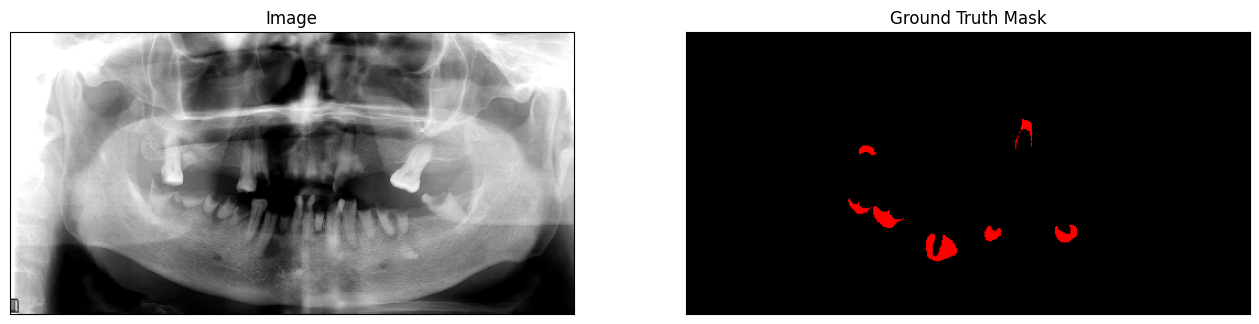

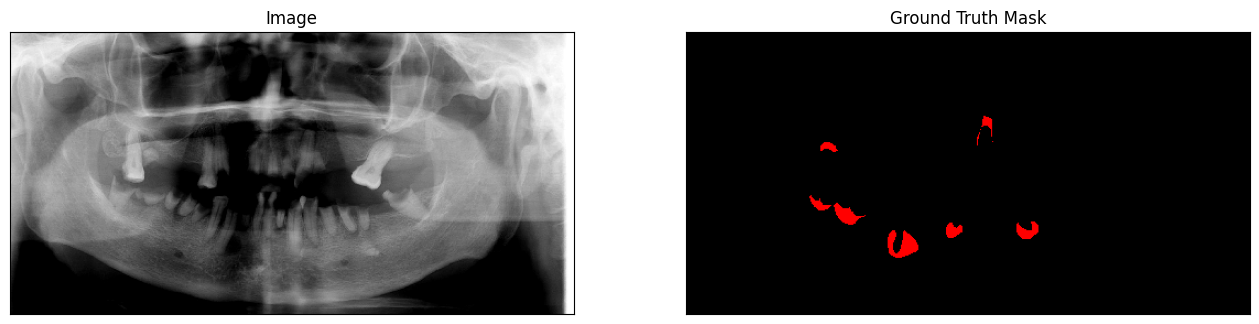

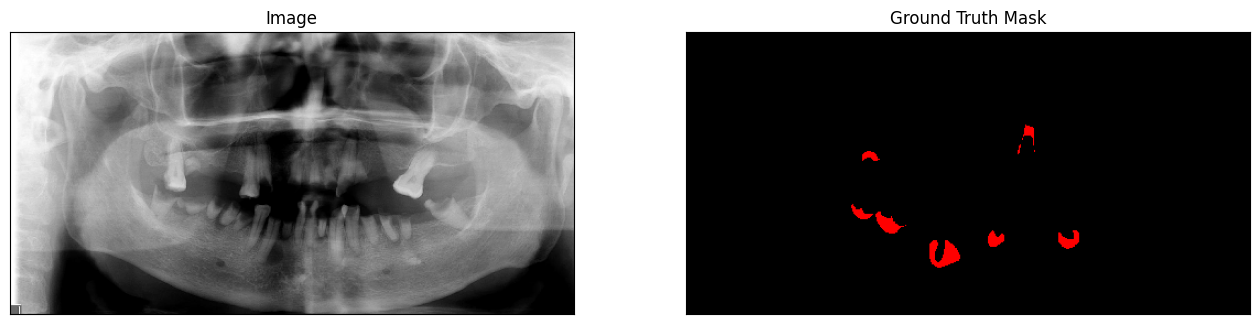

In [ ]:
#### Visualize resulted augmented images and masks
augmented_dataset = SegmentationDataset(
                            dataset_objs=train,
                            augmentation=get_training_augmentation(probs=(1.,1.,1.,1.,1.)))

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[0]
    visualize(image=image, gt_mask=mask)

del augmented_dataset

## Create model and train

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["BG", "benign_cyst_neoplasia", "developmental", "inflammation"]
ACTIVATION = 'softmax2d' # could be None for logits, sigmoid, or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3(
# model = smp.Unet(
# model = smp.MAnet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 85.3MB/s]


In [ ]:
train_dataset = SegmentationDataset(
      dataset_objs=train,
      augmentation=get_training_augmentation(),
      preprocessing=get_preprocessing(preprocessing_fn,),
)

valid_dataset = SegmentationDataset(
      dataset_objs=val,
      augmentation=get_validation_augmentation(),
      preprocessing=get_preprocessing(preprocessing_fn,),
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=0)

In [ ]:
images, masks = next(iter(train_loader))

In [ ]:
images.shape

torch.Size([16, 3, 256, 512])

In [ ]:
masks.shape

torch.Size([16, 4, 256, 512])

In [ ]:
import segmentation_models_pytorch.utils.metrics
from segmentation_models_pytorch import utils

In [ ]:
import torch
import torch.nn as nn

from segmentation_models_pytorch.utils import base
from segmentation_models_pytorch.utils import functional as F
from segmentation_models_pytorch.base.modules import Activation

class WeightedBinaryCELoss(base.Loss):
    def __init__(self, eps=1.0, beta=1.0, activation=None, ignore_channels=None, bg_penalty=100, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels
        self.bg_penalty = bg_penalty

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)

        # Apply thresholding
        y_pr = F._threshold(y_pr)

        # Take channels excluding the ones specified to be ignored
        y_pr, y_gt = F._take_channels(y_pr, y_gt, ignore_channels=self.ignore_channels)

        # Compute weighted binary cross-entropy loss
        loss = -((1 - y_gt) * torch.log(1 - y_pr + 1e-15) + y_gt * torch.log(y_pr + 1e-15))

        # Apply the penalty for misclassifying non-BG classes
        loss[:, 1:] *= self.bg_penalty

        return loss.mean()


In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

# loss = utils.losses.DiceLoss(ignore_channels=[0])
loss = WeightedBinaryCELoss()
metrics = [
    utils.metrics.IoU(ignore_channels=[0]),
    utils.metrics.Fscore(ignore_channels=[0])

]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0002),
])

In [ ]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs
max_score = 0

for i in range(30):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # update best model when performance improves on validation set
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './models/best_model.pth')
        print('Model saved!')
    if i in {5, 10, 15,20,25}:
        torch.save(model, f'./models/best_model_WBCE_{i}.pth')

    # if i == 80:
    #     optimizer.param_groups[0]['lr'] = 1e-5
    #     print('Decrease decoder learning rate to 1e-5!')

In [ ]:
torch.save(model, './models/best_model_WBCE_30.pth')

In [ ]:
torch.cuda.empty_cache()

## Test best saved model

In [ ]:
# load best saved checkpoint
# best_model = torch.load('./models/best_model.pth')
best_model = torch.load('./models/best_model_WBCE_30.pth')

In [ ]:
metrics = [
    utils.metrics.Accuracy(ignore_channels=[0]),
    utils.metrics.IoU(ignore_channels=[0]),
    utils.metrics.Fscore(ignore_channels=[0]),
    utils.metrics.Precision(ignore_channels=[0]),
    utils.metrics.Recall(ignore_channels=[0]),

]

In [ ]:
# create test dataset
test_dataset = SegmentationDataset(
      dataset_objs=test,
      augmentation=get_validation_augmentation(),
      preprocessing=get_preprocessing(preprocessing_fn,),
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

In [ ]:
# 12 epochs
test_epoch.run(train_loader) # dice_loss - 0.5793, iou_score - 0.2893, fscore - 0.4225
test_epoch.run(valid_loader) # dice_loss - 0.6502, iou_score - 0.6667, fscore - 0.6667
test_epoch.run(test_loader) # dice_loss - 0.6216, iou_score - 0.7055, fscore - 0.7055

valid: 100%|██████████| 146/146 [01:05<00:00,  2.22it/s, weighted_binary_ce_loss - 0.291, accuracy - 0.9994, iou_score - 0.7181, fscore - 0.7253, precision - 0.9532, recall - 0.7258]


{'weighted_binary_ce_loss': 0.29102854917387244,
 'accuracy': 0.9993569246710162,
 'iou_score': 0.7181389300349627,
 'fscore': 0.7253349380203292,
 'precision': 0.9531587577754501,
 'recall': 0.7258463189901483}

## Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = SegmentationDataset(
          dataset_objs=test,
)

abnormal = test_dataset_vis.has_abnormalities

In [ ]:
i = 0
num_displayed = 0
while num_displayed < 3 and i < len(test_dataset_vis):
    if not abnormal[i]:
        i+=1
        continue
    # get the original image, and ground truth mask of prediction for comparison
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0) # has shape torch.Size([1, 3, 256, 512])
    pr_mask = best_model.predict(x_tensor).squeeze() # has shape torch.Size([4, 256, 512])

    # Create a binary mask with 1 on the channel with the highest probability and 0 in the other channels
    predicted_classes = torch.argmax(pr_mask, dim=0)
    meshgrid = torch.meshgrid(torch.arange(pr_mask.shape[1]), torch.arange(pr_mask.shape[2]))
    binary_mask = torch.zeros_like(pr_mask)
    binary_mask[predicted_classes, meshgrid[0], meshgrid[1]] = 1
    binary_mask = binary_mask.cpu().numpy()

    # visualize original image, abnormality ground truth mask and predicted mask
    visualize(
        image=image_vis, # has shape (840, 1615, 1)
        gt_mask=gt_mask.transpose(1, 2, 0), # has shape (256, 512, 4)
        pr_mask=binary_mask.transpose(1, 2, 0) # has shape (256, 512, 4)
    )
    i+=1
    # num_displayed += 1

Output hidden; open in https://colab.research.google.com to view.